<h1>Big Five Personality Trends Over the COVID-19 Pandemic</h1>

<h2>Introduction and data loading</h2>

I will walk through the ongoing analyses I did in this notebook! The purpose of this analysis is primarily to determine the impact of the COVID-19 pandemic on population-level metrics of personality as measured by the Five Factor Model (the "Big Five"). 

I also perform a number of additional internal analyses on the dataset, all of which will be explained below.

First, we import the relevant packages and define a function that will help us later.

In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import copy
from datetime import datetime
from collections import Counter as count
import seaborn as sn
from matplotlib import pyplot as plt

In [2]:
def movingaverage(interval, window_size):
    window=np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

Next, we will load in all of the data (11/2019-03/2022), merge them into a single database, translate the date in each entry into a `datetime` object, sort the entire merged database by date, and discard all of the columns that are irrelevant for this analysis.

In [3]:
# load in CSVs

path = r'/Users/cameronberg/Truity research/Big 5 analyses/big5data/'
all_files = glob.glob(path + "/*.csv")

# concatenate CSVs
li = []
for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
print(f"CSVs have been concatenated. This dataframe contains personality data from {len(frame)} participants.")

# turn string dates into datetime objects and sort by recency
for i, r in tqdm(enumerate(frame['Submitted Time'])):  
    dt_obj = datetime.strptime(frame['Submitted Time'][i][:10], '%m/%d/%Y')
    frame.at[i, 'Submitted Time'] = dt_obj  
    
frame = frame.sort_values(by=['Submitted Time'])
print("Dataframe has been sorted by date.")

# permanently drop irrelevant columns
to_drop1 = ['Basic/Full', 'UID', 'Username', 'o_percent', 'c_percent', 'e_percent', 'a_percent', 'n_percent', 'oa_hi_hi', 'oa_hi_lo', 'oa_lo_hi', 'oa_lo_lo', 'ea_hi_hi', 'ea_hi_lo', 'ea_lo_hi', 'ea_lo_lo', 'eo_hi_hi', 'eo_hi_lo', 'eo_lo_hi', 'eo_lo_lo', 'en_hi_hi', 'en_hi_lo', 'en_lo_hi', 'en_lo_lo', 'cn_hi_hi', 'cn_hi_lo', 'cn_lo_hi', 'cn_lo_lo', 'co_hi_hi', 'co_hi_lo', 'co_lo_hi', 'co_lo_lo', 'on_hi_hi', 'on_hi_lo', 'on_lo_hi', 'on_lo_lo', 'ce_hi_hi', 'ce_hi_lo', 'ce_lo_hi', 'ce_lo_lo', 'an_hi_hi', 'an_hi_lo', 'an_lo_hi', 'an_lo_lo', 'o_cutoff_hi', 'o_cutoff_lo', 'c_cutoff_hi', 'c_cutoff_lo', 'e_cutoff_hi', 'e_cutoff_lo', 'a_cutoff_hi', 'a_cutoff_lo', 'n_cutoff_hi', 'n_cutoff_lo']
to_drop2 =['Have you ever been asked to take a personality test as part of a job application?',
       'To what extent do you have a “work persona,” or a different way of acting at work?',
       'How do you think your personality has affected your career success?',
       'In evaluations of your performance in your current job, what is given the most emphasis?',
       'What is the highest level of education you have completed?', 'latino',
       'amnative', 'asian', 'black', 'hinative', 'white']

to_drop = to_drop1 + to_drop2
frame.drop(to_drop, axis=1, inplace=True)

print("Irrelevant columns have been dropped.")

 25%|██▌       | 5/20 [00:21<00:50,  3.40s/it]/Users/cameronberg/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
 35%|███▌      | 7/20 [00:28<00:47,  3.67s/it]/Users/cameronberg/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
100%|██████████| 20/20 [02:05<00:00,  6.27s/it]
0it [00:00, ?it/s]

CSVs have been concatenated. This dataframe contains personality data from 2839301 participants.


2839301it [05:40, 8350.03it/s] 


Dataframe has been sorted by date.
Irrelevant columns have been dropped.


<h2>Quick internal validity assessment</h2>

Before performing any manipulations, let's simply check how correlated trait scores are. The Five Factor Model posits that these traits are conceptually and psychologically distinct. The lower the inter-trait correlations, the more plausible it is that this assumption is correct. As we find below, trait scores indeed demonstrate low correlation, with two notable exceptions: neuroticism and conscientiousness, and neuroticism and extraversion. In both cases, neuroticism is substantially negatively correlated with the other trait. In other words, the higher an individual is in neuroticism, the lower they are likely to be in conscientiousness and extraversion—and vice versa.

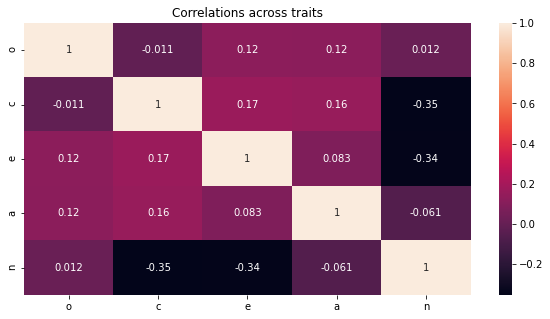

In [4]:
total_corr = frame[['o', 'c', 'e', 'a', 'n']]
total_corr = total_corr.corr()
sn.heatmap(total_corr, annot=True, xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title(f"Correlations across traits")
plt.show()

<h2>Trait averages across 2-year period</h2>

Next, in order to determine population-level changes in traits over time, we will go through the entire database day by day and take the average trait score for that day. We will repeat this analysis for each trait. Note that given the enormous size of the dataset, this takes roughly 10 minutes per trait!

In [5]:
import numpy as np

o, c, e, a, n = [], [], [], [], []
for y in ['o', 'c', 'e', 'a', 'n']:
    li = eval(y)
    for x in tqdm(sorted(set(list(frame['Submitted Time'])))):
        if len(frame[frame['Submitted Time'] == x][y]) >= 100:
            li.append(np.mean(frame[frame['Submitted Time'] == x][y]))
        else:
            li.append(np.nan)

100%|██████████| 844/844 [07:25<00:00,  1.89it/s]


Now, we have five lists—one for each trait—populated with daily average scores for that trait, spanning from 11/05/2019 to 2/28/2022. This works out to 844 days in total.

We can now visualize these averages for each trait. Notice that there are some gaps in the plot—this is because the above code only takes averages on days where >100 people took the Big Five assessment. This was done to ensure trait averages are meaningful. Without this manipulation, we will see extremely jagged and statistically unreliable trends in trait averages across time, which makes the plot harder to interpret.

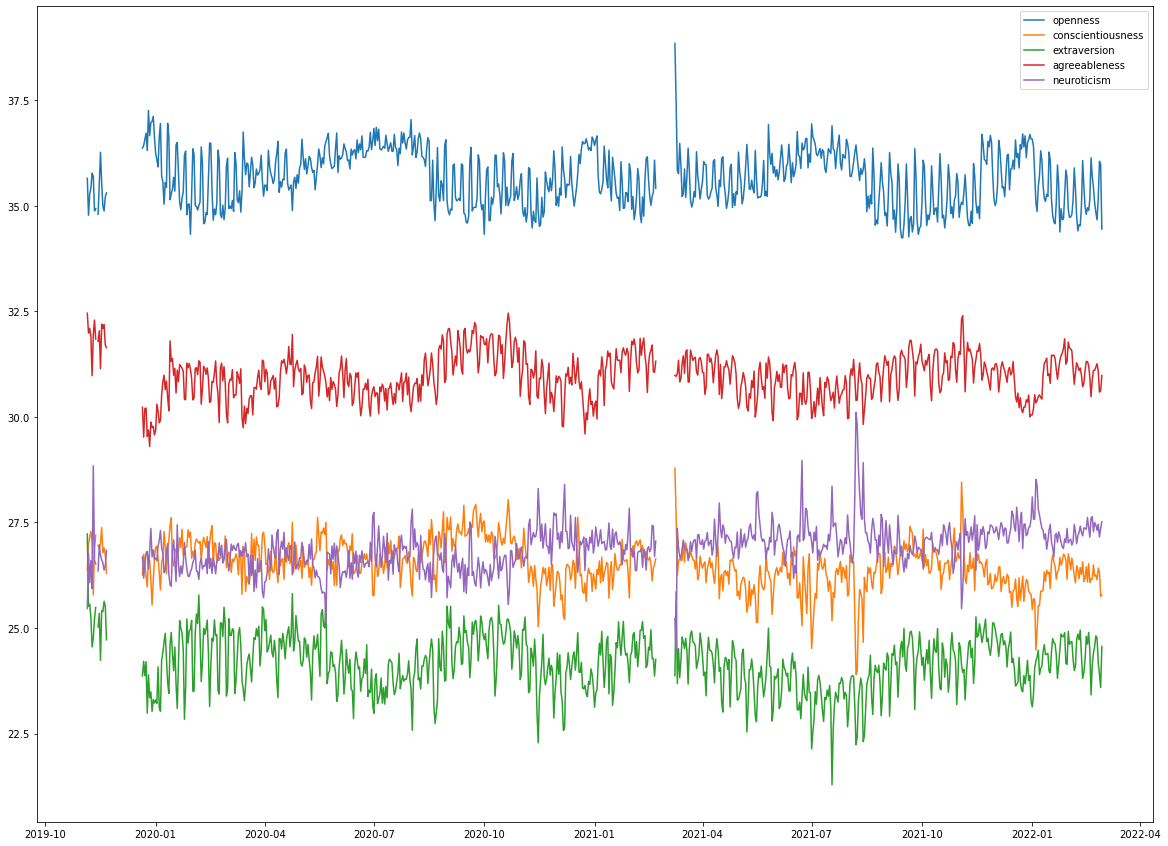

In [6]:
from matplotlib import pyplot as plt, dates as dt

dates = sorted(set(list(frame['Submitted Time'])))

plt.rcParams["figure.figsize"] = (20,15)
plt.plot(dates, o, label='openness')
plt.plot(dates, c, label='conscientiousness')
plt.plot(dates, e, label='extraversion')
plt.plot(dates, a, label='agreeableness')
plt.plot(dates, n, label='neuroticism')
# plt.axvline(x=)
plt.legend()
plt.show()

We can also independently visualize each trait average over time. The red horizontal line on each plot denotes the overall daily average across the ~2 years.

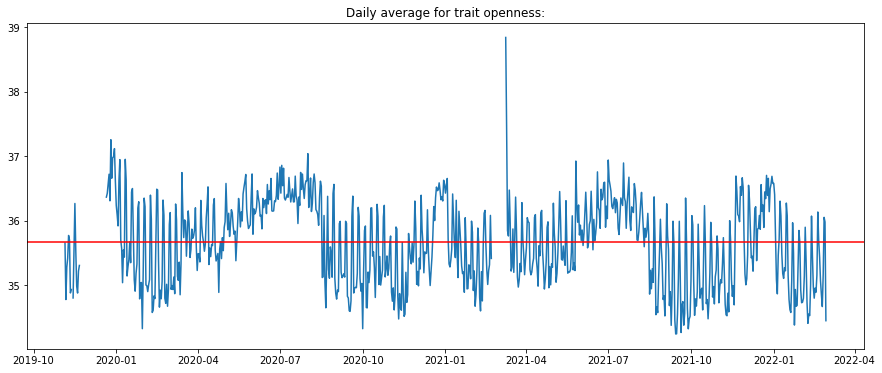

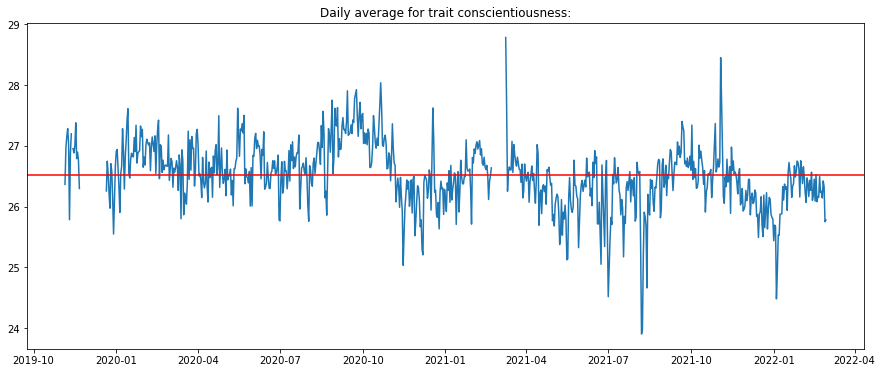

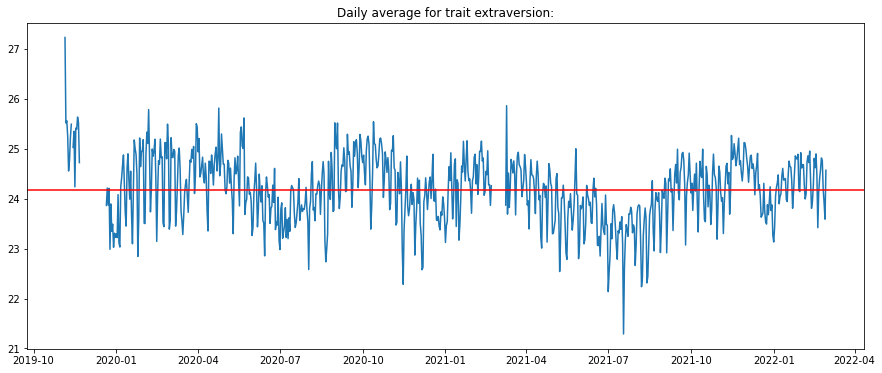

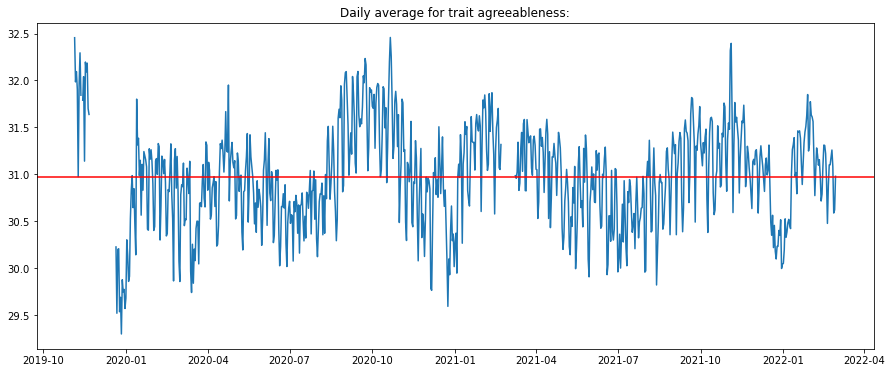

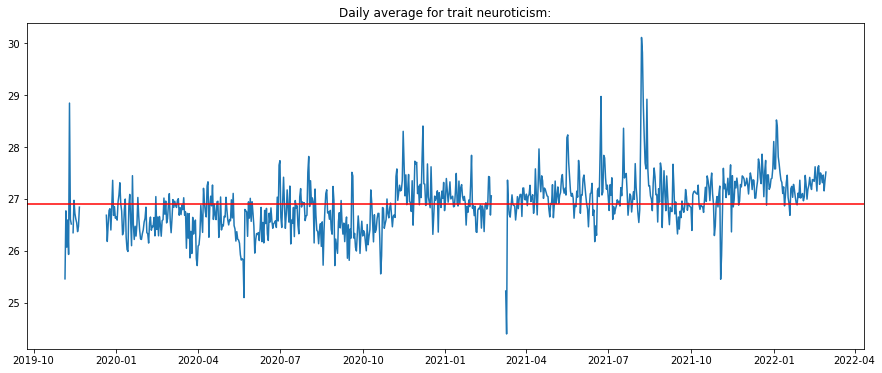

In [7]:
labels = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
for i, x in enumerate([o, c, e, a, n]):
    plt.rcParams["figure.figsize"] = (15,6)
    plt.plot(dates, x, label=labels[i])
    plt.axhline(y=np.nanmean(x), color='r', linestyle='-')
    plt.title(f"Daily average for trait {labels[i]}:")
    plt.show()

We might notice that these curves are quite jagged. (We will explore one intriguing hypothesis as to why this is the case in the next cell!) We can use our `movingaverage` function defined above to convolve each plot and return a smoothed running average for each trait. These are less noisy plots and therefore easier to interpret.

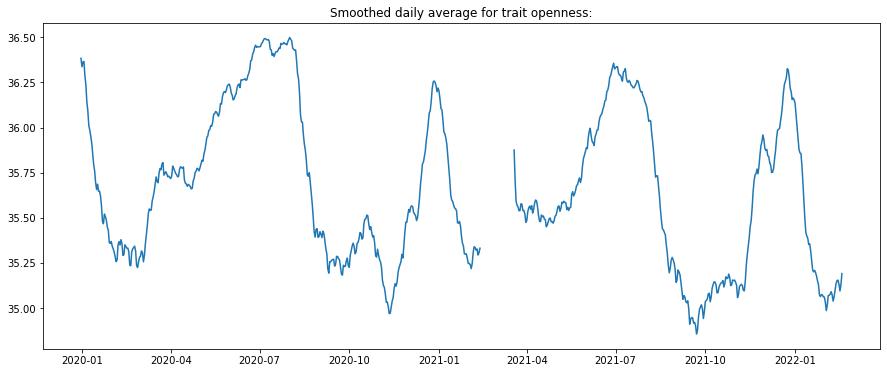

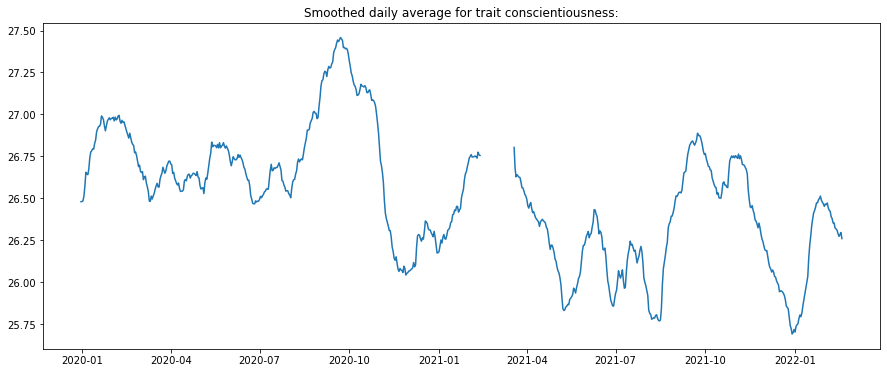

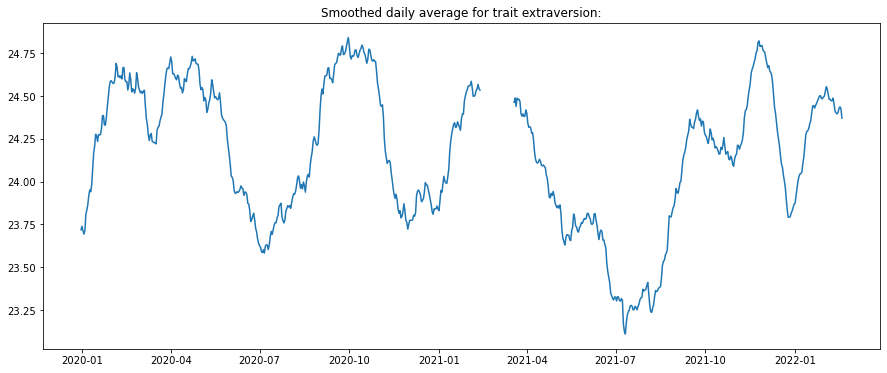

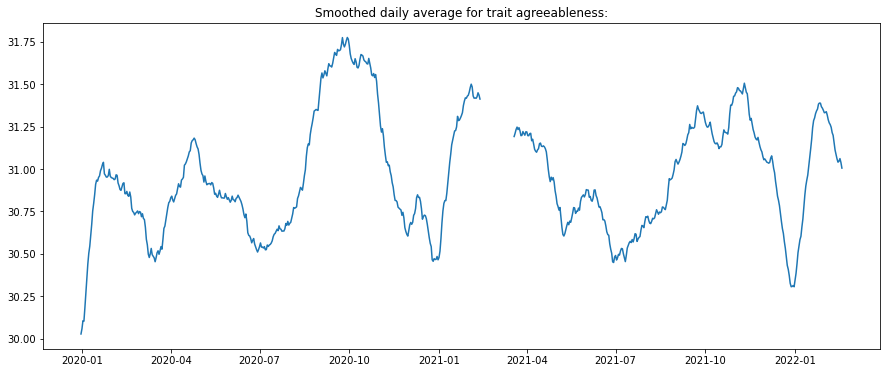

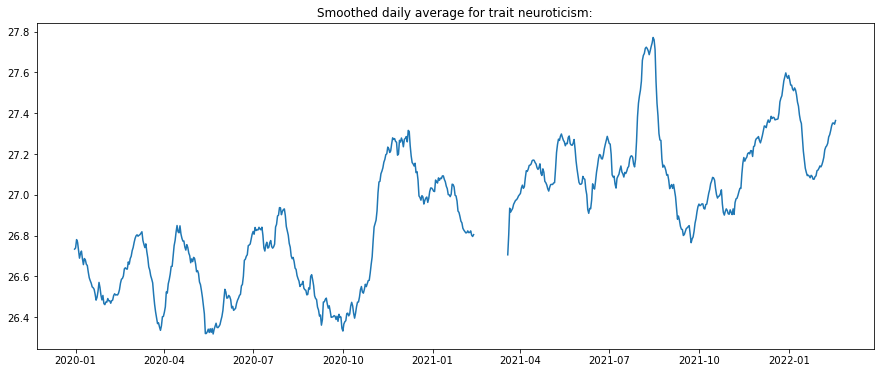

In [8]:
labels = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
for i, x in enumerate([o, c, e, a, n]):
    plt.rcParams["figure.figsize"] = (15,6)
    x = movingaverage(x, 20)
    plt.plot(dates[10:len(dates)-10], x[10:len(x)-10], label=labels[i])
    plt.title(f"Smoothed daily average for trait {labels[i]}:")
    plt.show()

There are some very interesting trends to consider here.

**Openness** demonstrates highly periodic behavior across the year: it is high around Christmas, steadily drops until April, stays roughly flat until May, steadily rises until August, and crashes through the fall, before steadily rising again until Christmas. I am currently unsure of what to make of this trend. Perhaps the summer allows people extra time to pursue creative/interesting ventures, which is reflected in higher trait averages? 

**Conscientiousness** demonstrates peaks in January/February as well as late September/early October. This makes sense, given that these are two key 'back-to-work/school' periods. It seems that conscientiousness scores are globally decreasing across time (this may relate in interesting ways to the 'Great Resignation'). 

**Extraversion** stays higher in the spring and fall and lower in the winter and summer. Perhaps there is greater activity during the spring and fall than during the winter and summer, which corresponds to higher enthusiasm and excitement in these periods.

**Agreeableness** demonstrates a highly similar year-round dynamic to extraversion. This is also reflected in the correlation matrix below.

**Neuroticism** seems to stay lower throughout the year and increase in the winter. Just as conscientiousness seems to be globally decreasing across time, neuroticism seems to be globally increasing across time. (This is not particularly surprising!)

<h2>Correlations between daily trait scores over time</h2>

We can refer to to correlation matrix below to determine the relationship between these traits' trends across time. Highly positive correlations would incidate that trait scores are exhibiting similar behavior across time, while highly negative correlations would indicate that trait scores are exhibiting different behavior across time.

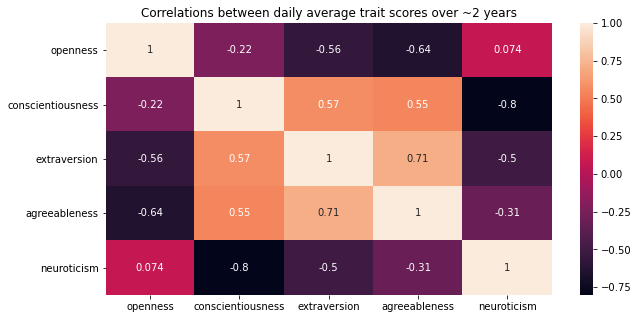

In [10]:
corr = pd.DataFrame(np.array([o, c, e, a, n]).T, columns=labels)
corr_arr = corr.corr()
sn.heatmap(corr_arr, annot=True, xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.title(f"Correlations between daily average trait scores over ~2 years")
plt.show()

There are two clusters of results to note here. 

First, trends in both openness and neuroticism across time are strongly negatively predictive of trends in conscientiousness, extraversion, and agreeableness—but not in the same way. Specifically, openess trends are most negatively predict of agreeableness trends, followed by extraversion trends, followed by conscientiousness trends. Conversely, neuroticism trends are most negatively predictive of conscientiosuess trends, followed by extraversion trends, followed by agreeableness trends (the reverse of openess). As such, openness trends and neuroticism trends are not predictive of each other.

Second, trends in conscientiousness, extraversion, and agreeableness are all highly correlated. 

Particularly striking are neuroticism x conscientiousness (r=-.8), and agreeableness x extraversion (r=.71). Recall that (a) neuroticism seems to be globally increasing while conscientiousness seem to be globally decreasing, and (b) agreeableness and extraversion both seem to increase in the spring and fall and decrease in the winter and summer.

<h2>Truity's FFM Data x COVID Tracking Project</h2>

Now, we are ready to examine the relationship between average daily trait scores and various metrics captured over the course of the COVID-19 pandemic. In order to do this, we import a database from the COVID Tracking Project called `national-history.csv`, which documents national statistics including total COVID-19 deaths, the number of current hospitalized COVID-19 patients, the number of current COVID-19 patients in the ICU, and more.

We load in this dataset, sort it by date, merge this with the daily trait averages, and plot the correlation matrix between the personality data and the COVID-19 data.

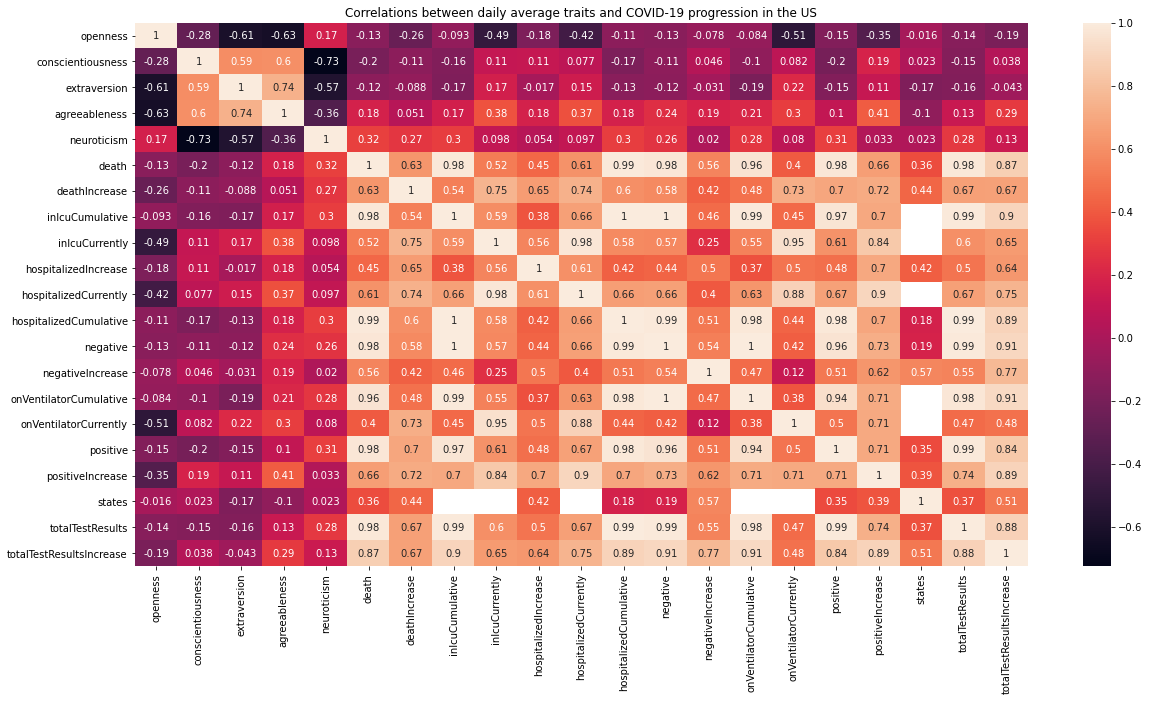

In [11]:
covid_data = pd.read_csv("national-history.csv")
for i, r in enumerate(covid_data['date']):  
    dt_obj = datetime.strptime(covid_data['date'][i], '%Y-%m-%d')
    covid_data.at[i, 'date'] = dt_obj  

beg = sorted(set(list(frame['Submitted Time'])))[0]

covid_data = covid_data[covid_data['date'] > beg]
covid_data.sort_values(by=['date'], inplace=True)
covid_data = covid_data.reset_index(drop=True)

corr.drop(corr.tail(len(corr)-420).index, inplace=True)

covid_stuff = pd.concat([corr, covid_data], axis=1)

cov = covid_stuff.corr()
sn.heatmap(cov, annot=True, xticklabels=True, yticklabels=True)
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.title(f"Correlations between daily average traits and COVID-19 progression in the US")
plt.show()

We can conceptually divide the correlation matrix into four quadrants. 

The upper left quadrant is basically equivalent to the correlation matrix in the previous cell (the numbers are not identical because this newer matrix only uses a subset of the personality data given that COVID began significantly after 11/2019).

The lower right quadrant documents internal correlations to the COVID-19 national data. While interesting, this is not the relevant part of our analysis.

The relevant quadrants (personality x COVID) are therefore the **lower left** and/or **upper right** (these are equivalent). Across all of the COVID metrics, the following general picture emerges: increases in proxies for COVID-19 getting worse **significantly positively** correlate with agreeableness and neuroticism, **significantly negatively** correlate with openness, and demonstrate no especially strong relationship with extraversion or conscientiousness. 

**All correlations with an absolute value of .16 or higher are significant at p<.001.**

Particularly noteworthy are the following correlations:
- neuroticism x death (r=.32, p<.00001)
- neuroticism x positive (cumulative) (r=.31, p<.00001)
- neuroticism x hospitalizedCumulative (r=.30, p<.00001)
- neuroticism x inIcuCumulative (r=.30,p<.00001)


- agreeableness x positiveIncrease (r=.41, p<.00001)
- agreeableness x inIcuCurrently (r=.38, p<.00001)
- agreeableness x hospitalizedCurrently (r=.37, p<.00001)
- agreeableness x onVentilatorCurrently (r=.30, p<.00001)

Notice how neuroticism seems to track cumulative metrics of the pandemic, while agreeableness seems to track current/ongoing metrics of the pandemic. We can likely differentiate long-term 'pandemic exhaustion' and short-term 'willingness to do one's part' in this way.

- openness x onVentilatorCurrently (r=-.51, p<.00001)
- openness x inIcuCurrently (r=-.49, p<.00001)
- openness x hospitalizedCurrently (r=-.42, p<.00001)
- openness x positiveIncrease (r=-.35, p<.00001)

Notice how, like agreeableness, openness seems to track current/ongoing metrics of the pandemic. The key difference is that while agreeableness increases in proportion to increases in these metrics, openness significantly decreases. This makes sense: the drives associated with openness (creativity, exploration, adventure, beauty-seeking, wonder, etc.) can be thought of as 'higher' on Maslow's hierarchy of needs. In other words, the part of people that engages with these abstract and more sophisticated endeavors is likely 'shut off' in medical emergencies.

Finally, the finding that positive increases in cases were significantly correlated with conscientiousness (r=.19, p=.000089) tracks with findings that prevelence of infectious disease in a country predicts levels of conservatism in that country (Murray et al, 2013), a political temperament that is in turn associated with conscientiousness (Carney et al, 2008).

<h2>Trait differences above/below pandemic-wide metric averages</h2>

To continue with COVID-19 x Big Five analyses, we will start by taking the 'ongoing' COVID-19 trends (i.e., death*Increase*, inIcu*Currently*, etc.), plot these trends across the entire pandemic, and calculating the average value of that trend across the entire pandemic.

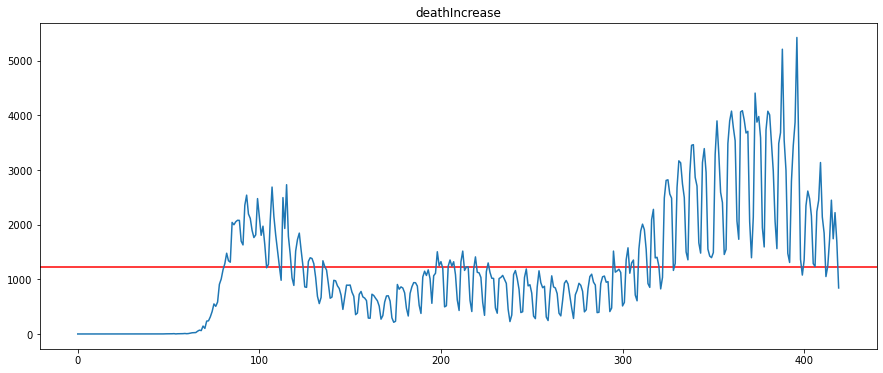

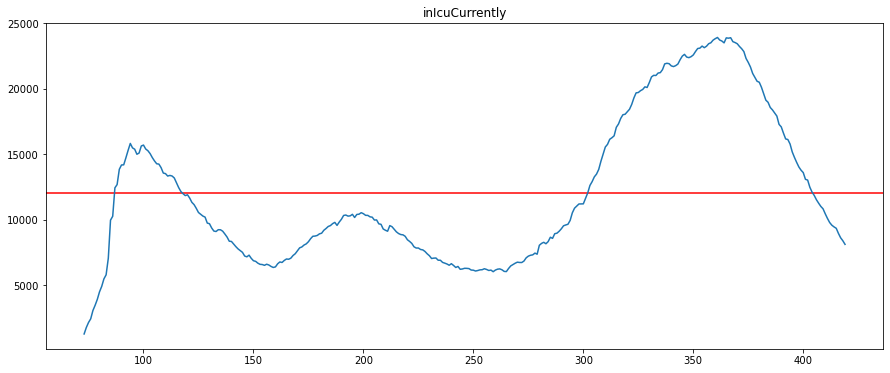

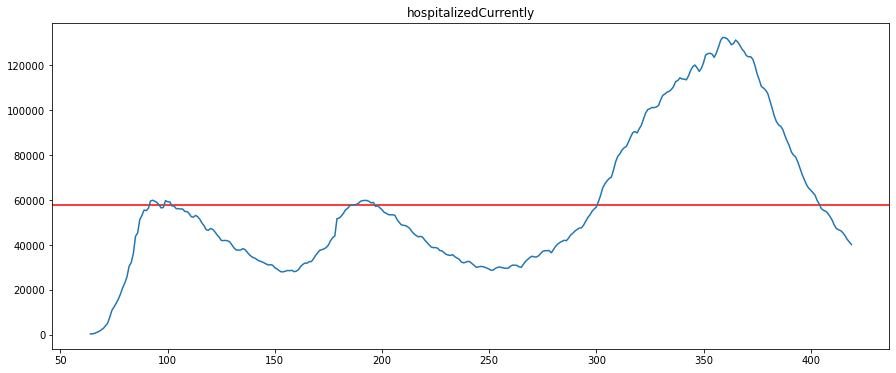

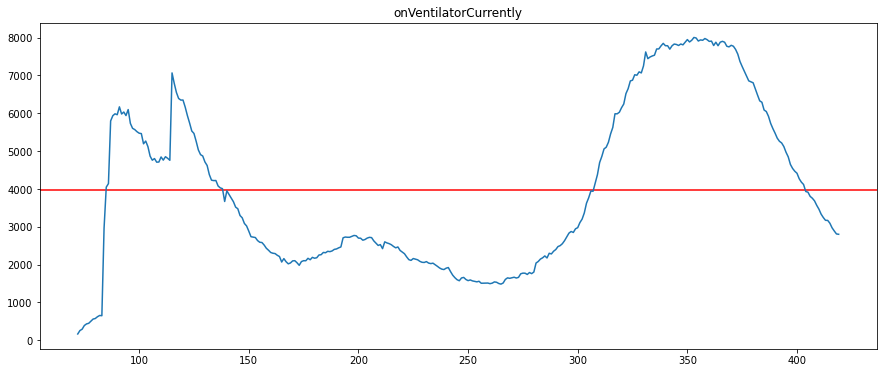

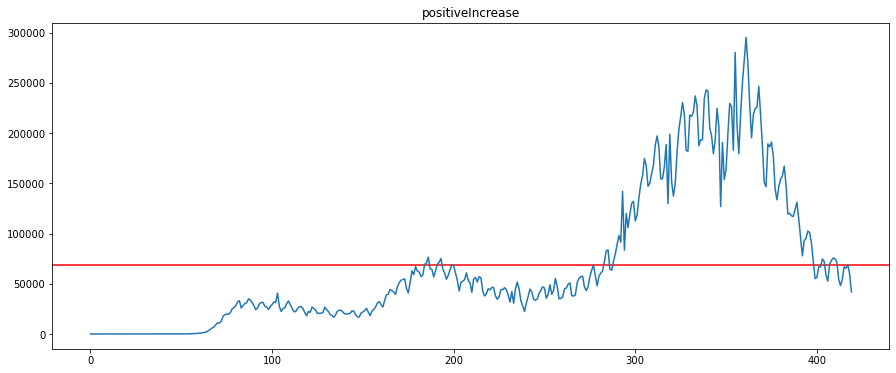

In [12]:
covid_predictors = ['deathIncrease','inIcuCurrently','hospitalizedCurrently',
                    'onVentilatorCurrently', 'positiveIncrease']
for x in covid_predictors:
    plt.axhline(y=np.nanmean(covid_stuff[x]), color='r', linestyle='-')
    plt.plot(range(len(covid_stuff[x])), covid_stuff[x])
    plt.title(x)
    plt.show()

Now, we will do the following:

- For each COVID-19 trend, divide dates into two categories: (1) dates in which the trend datapoint was lower than the pandemic-wide average, and (2) dates in which the trend datapoint was greater than the pandemic-wide average. For example, the average number of people in the ICU throughout the entire pandemic was roughly 12,000, so we can simply find those dates where the number of COVID patients in the ICU was less than 12,000 and those dates where the number of COVID patients in the ICU was greater than 12,000.


- Once dates have been split into two groups for each COVID trend, and we can now compare trait averages across these two date-group ranges to see if there are significant differences using a simple t-test. For example, we can ask questions like, *did people exhibit significant differences in neuroticism when the number of hospitalized COVID patients was greater than vs. less than the overall pandemic average?*

In [13]:
from scipy.stats import ttest_ind as ttest

for x in covid_predictors:
    less_mean_dates, greater_mean_dates = [], []
    for i,y in enumerate(covid_stuff[x]):
        if y > np.mean(covid_stuff[x]):
            greater_mean_dates.append(covid_stuff.loc[i,'date'])
        else:
            less_mean_dates.append(covid_stuff.loc[i,'date'])
    
    t1l, t2l, t3l, t4l, t5l = [], [], [], [], []
    t1g, t2g, t3g, t4g, t5g = [], [], [], [], []
    for z in less_mean_dates:
        t1l.append(covid_stuff.loc[covid_stuff['date'] == z]['openness'])
        t2l.append(covid_stuff.loc[covid_stuff['date'] == z]['conscientiousness'])
        t3l.append(covid_stuff.loc[covid_stuff['date'] == z]['extraversion'])
        t4l.append(covid_stuff.loc[covid_stuff['date'] == z]['agreeableness'])
        t5l.append(covid_stuff.loc[covid_stuff['date'] == z]['neuroticism'])
    for z in greater_mean_dates:
        t1g.append(covid_stuff.loc[covid_stuff['date'] == z]['openness'])
        t2g.append(covid_stuff.loc[covid_stuff['date'] == z]['conscientiousness'])
        t3g.append(covid_stuff.loc[covid_stuff['date'] == z]['extraversion'])
        t4g.append(covid_stuff.loc[covid_stuff['date'] == z]['agreeableness'])
        t5g.append(covid_stuff.loc[covid_stuff['date'] == z]['neuroticism'])
      
    print()
    print()
    print(f"Comparison of trait means when {x} is greater than/less than pandemic average:")
    print()
    stat1, result1 = ttest(t1l, t1g, nan_policy='omit')
    stat2, result2 = ttest(t2l, t2g, nan_policy='omit')
    stat3, result3 = ttest(t3l, t3g, nan_policy='omit')
    stat4, result4 = ttest(t4l, t4g, nan_policy='omit')
    stat5, result5 = ttest(t5l, t5g, nan_policy='omit')
    print(f"openness: t={round(float(stat1[0]),8)}, p={round(float(result1),8)}")
    print()
    print(f"conscientiousness: t={round(float(stat2[0]),8)}, p={round(float(result2),8)}")
    print()
    print(f"extraversion: t={round(float(stat3[0]),8)}, p={round(float(result3),8)}")
    print()
    print(f"agreeableness: t={round(float(stat4[0]),8)}, p={round(float(result4),8)}")
    print()
    print(f"neuroticism: t={round(float(stat5[0]),8)}, p={round(float(result4),8)}")
    print()
    
    
#     print(np.nanmean(t1l), np.nanmean(t1g))
#     print(np.nanmean(t2l), np.nanmean(t2g))
#     print(np.nanmean(t3l), np.nanmean(t3g))
#     print(np.nanmean(t4l), np.nanmean(t4g))
#     print(np.nanmean(t5l), np.nanmean(t5g))



Comparison of trait means when deathIncrease is greater than/less than pandemic average:

openness: t=6.27980232, p=0.0

conscientiousness: t=0.3499124, p=0.72659284

extraversion: t=-0.10801857, p=0.91403637

agreeableness: t=-1.7768644, p=0.07636794

neuroticism: t=-3.49640568, p=0.07636794



Comparison of trait means when inIcuCurrently is greater than/less than pandemic average:

openness: t=11.28333098, p=0.0

conscientiousness: t=-2.19616229, p=0.02866694

extraversion: t=-3.08601038, p=0.00217302

agreeableness: t=-5.94115604, p=1e-08

neuroticism: t=-2.27909922, p=1e-08



Comparison of trait means when hospitalizedCurrently is greater than/less than pandemic average:

openness: t=7.5876715, p=0.0

conscientiousness: t=-3.0202669, p=0.00269135

extraversion: t=-2.09728486, p=0.03661002

agreeableness: t=-6.77263707, p=0.0

neuroticism: t=-0.94816452, p=0.0



Comparison of trait means when onVentilatorCurrently is greater than/less than pandemic average:

openness: t=10.4648

In summary:
- Only openness exhibited a significant difference when the increase in deaths was greater than/less than pandemic average. Openness was significantly lower in the former condition.


- All traits exhibited a significant difference when the increase in the number of COVID patients in the hospital, in the ICU, and on a ventilator was greater than/less than pandemic average (with the sole exception of conscientiousness in the ventilator condition).


- All traits with the exception of extraversion exhibited a significant difference when the increase in positive COVID cases was greater than/less than pandemic average.

<h2>Summary of Big Five x COVID-19 findings</h2>

Overall, we find that agreeableness and neuroticism scores generally increased as the pandemic got worse and decreased as the pandemic got better. More specifically, agreeableness scores increased most strongly in response to shorter-term, transient worsening of the pandemic (e.g., hospitalization spikes), while neuroticism scores increased most strongly in response to longer-term, cumulative worsening of the pandemic (e.g., cumulative deaths). Openness significantly decreased in response to the shorter-term, transient worsening of the pandemic. Conscientiousness and extraversion did not show particularly significant trends in either direction.